## Cargar librerías

In [60]:
import matplotlib.pyplot as plt
import requests, re, os, glob
import pandas as pd
import numpy as np
import seaborn as sns

## Cambiar directorio

In [61]:
#os.chdir("/content/drive/MyDrive/PRONACES/python")
#Show directory
os.getcwd()

'c:\\Users\\pedro\\Documents\\programación\\python\\pronaces_analisis'

## Lista de archivos RETC

In [62]:
retcFiles = glob.glob("data/RETC_2004-2020/retc*.xlsx")
retcFiles[:5]

['data/RETC_2004-2020\\retc 2004.xlsx',
 'data/RETC_2004-2020\\retc 2005.xlsx',
 'data/RETC_2004-2020\\retc 2006.xlsx',
 'data/RETC_2004-2020\\retc 2007.xlsx',
 'data/RETC_2004-2020\\retc 2008.xlsx']

In [63]:
unidades = {
    "ton":1,
    "ton/año":1,
    "kg":1/1000,
    "Kg":1/1000,
    "kg/año":1/1000,
    "g":1/(1000*1000),
    
}
columnasContaminantes = [
    'AIRE', 'AGUA', 'SUELO', 'REUTILIZACIÓN', 'RECICLADO',
    'COPROCESAMIENTO', 'TRATAMIENTO', 'DISPOSICIÓN\nFINAL',
    'ALCANTARILLADO', 'INCINERACIÓN', 'OTROS']

## Read RETC file

In [64]:
def ReadRECTFile(file):
  df = pd.ExcelFile(file)
  sheetNames = df.sheet_names
  gral = df.parse(sheetNames[0])
  emisiones = df.parse(sheetNames[1])
  return gral, emisiones

def FindColumnsIndex(df):
  for i in range(len(df)):
    row = df.iloc[i,0] 
    try:
      row = row.lower()
    except:
      continue
    if "NRA".lower() in row:
      return i
  return -1

def FixColumns(df):
  Index = FindColumnsIndex(df)
  df.columns = df.iloc[Index]
  df = df.iloc[Index+1:]
  df.columns = df.columns.str.lower()
  return df

retcEmisiones = pd.DataFrame()
retcGral = pd.DataFrame()

for file in retcFiles:
  gral, emisiones = ReadRECTFile(file)

  emisiones = FixColumns(emisiones)
  gral = FixColumns(gral)

  #Filter both dataframes by estado = "COLIMA"
  
  try:
    emisiones = emisiones[emisiones["estado"] == "COLIMA"].copy()
    gral = gral[gral["estado"] == "COLIMA"].copy()
    
    emisiones.rename(columns={"descripción":"sustancia",
                              "no. cas":"cas"}, inplace=True)
  except:
  
    emisiones.rename(columns={
      "entidad federativa":"estado",
      }, inplace=True)
    gral.rename(columns={"entidad federativa":"estado"}, inplace=True)
    
    emisiones = emisiones[emisiones["estado"] == "COLIMA"].copy()
    gral = gral[gral["estado"] == "COLIMA"].copy()
  
  # Find column index of "unidad"
  unidadIndex = emisiones.columns.get_loc("unidad")
  emisiones["unidad"] = emisiones["unidad"].map(unidades)
  
  contaminante = emisiones.columns[unidadIndex+1:]

  # Multiply columns of emisiones in contaminantes list by column "unidad"
  for col in contaminante:
    #emisiones[col].fillna(0, inplace=True)
    emisiones[col] = emisiones[col] * emisiones["unidad"]
    
  year = int(file[-9:-5])
  emisionesMelted = emisiones.melt(
    id_vars = emisiones.columns[:unidadIndex], 
    value_vars = contaminante, 
    var_name = "contaminante", 
    value_name = "emision")
  emisionesMelted["year"] = year
  
  gral["year"] = year
  gral.rename(columns={
    "delegación\municipio":"municipio",
    'coordenada\nutm x':'coordenada utm x', 
    'coordenada\nutm y':'coordenada utm y',
    'coordenada \nutm x':"coordenada utm x", 
    'coordenada \nutm y':"coordenada utm y",
    'latitud \nnorte' :'latitud norte',  
    'longitud \noeste':'longitud oeste',
    'número exterior':'núm. ext',
    'número interior':'núm. int',
    'no. exterior':'núm. ext', 
    'no. interior':'núm. int',
    'c.p.':"código postal",
    'clave\nambiental':'clave ambiental',
    'principal actividad productiva':'actividad principal',
    
    }, inplace=True)
  #emisionesMelted.drop(columns="municipio", inplace=True)
  
  emisionesMelted = emisionesMelted.merge(gral[[
     "nra",
     'latitud norte', 'longitud oeste', 'municipio','localidad'
     ]], on="nra", how="left")
  
  retcEmisiones = pd.concat([retcEmisiones, emisionesMelted], ignore_index=True)
  
  retcGral = pd.concat([retcGral, gral], ignore_index=True)

#emisiones["unidad"] = emisiones["unidad"].map(unidades)
# Fill NaN values from "municiopio" column with "municipio_x" column
retcEmisiones["municipio"].fillna(retcEmisiones["municipio_x"], inplace=True)
# Fill NaN values from "nombre" column with "establecimiento" column
retcEmisiones["nombre"].fillna(retcEmisiones["establecimiento"], inplace=True)

retcEmisiones.drop(columns=["municipio_x", "municipio_y", "establecimiento","grupo sustancia"], inplace=True)
retcEmisiones

,nra,nombre,estado,sector,sustancia,cas,contaminante,emision,year,latitud norte,longitud oeste,municipio,localidad
0,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Cromo (compuestos),S/C3,aire,0.047,2004,"18°58'43""","103°52'18""",Tecoman,CALERAS
1,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Bióxido de carbono,124-38-9,aire,1035641.88,2004,"18°58'43""","103°52'18""",Tecoman,CALERAS
2,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Cianuro inorgánico/orgánico,57-12-5,aire,NaN,2004,"18°58'43""","103°52'18""",Tecoman,CALERAS
3,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,6.152,2004,"18°58'43""","103°52'18""",Tecoman,CALERAS
4,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Mercurio,7439-97-6,aire,0.078,2004,"18°58'43""","103°52'18""",Tecoman,CALERAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12469,TSHBB0600711,"TERMINAL DE SERVICIOS HAZESA S.A. DE C.V.,TERM...",COLIMA,Petroleo y petroquimica,Plomo (compuestos),Pb,otros,0.0,2020,"19°4'35""","104°17'3""",Manzanillo,MANZANILLO
12470,UME750600911,"USG MEXICO, S.A DE C.V,USG MEXICO, S.A. DE C.V...",COLIMA,Cemento y Cal,Bióxido de carbono,124-38-9,otros,0.0,2020,"18°57'46""","103°53'28""",Tecoman,TECOMAN
12471,UME750600911,"USG MEXICO, S.A DE C.V,USG MEXICO, S.A. DE C.V...",COLIMA,Cemento y Cal,"Níquel (polvos respirables, humos o vapores)",7440-02-0,otros,0.0,2020,"18°57'46""","103°53'28""",Tecoman,TECOMAN
12472,YCS750600611,"YESERA COLIMA SA DE CV,YESERA COLIMA",COLIMA,Cemento y Cal,Bióxido de carbono,124-38-9,otros,0.0,2020,"19°4'1""","103°46'7""",Ixtlahuacan,IXTLAHUACAN


In [65]:
retcEmisionesNoNaN = retcEmisiones[retcEmisiones["emision"].notna()].copy()
# Keep only rows with "emision" column upper than 0
municipalitiesToKeep = ['Tecoman', 'Manzanillo', 'Colima', 'Cuauhtemoc', 'Minatitlan']
retcEmisionesNoNaN = retcEmisionesNoNaN[retcEmisionesNoNaN["municipio"].isin(municipalitiesToKeep)].copy()
retcEmisionesNoNaN = retcEmisionesNoNaN[retcEmisionesNoNaN["emision"] > 1].copy()

In [66]:
# Replace content of "nombre" column if contains "CEMENTOS APASCO S.A. DE C.V.	"
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nombre"].str.contains("APASCO"), "nombre"] = "CEMENTOS APASCO S.A. DE C.V."
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nombre"].str.contains("COMISIÓN FEDERAL DE ELECTRICIDAD"), "nombre"] = "CENTRAL TERMOELECTRICA MANZANILLO"
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nombre"].str.contains("CONSORCIO MINERO BENITO"), "nombre"] = 'PEÑA COLORADA'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nombre"].str.contains("Danisco Mexicana S.A. de C.V.	"), "nombre"] = 'DANISCO MEXICANA, S.A. DE C.V.'



In [67]:
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("DMEBF0600911"), "nombre"] = 'DANISCO MEXICANA, S.A. DE C.V.'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("ENC110600511"), "nombre"] = 'LAS ENCINAS S.A. DE C.V. PLANTA PELETIZADORA'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("UME750600911"), "nombre"] = 'USG MEXICO S.A. DE C.V.'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("PTA640600911"), "nombre"] = 'PRODUCTOS TANIART S.A DE C.V'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("MAR1Z0600711"), "nombre"] = 'MARINDUSTRIAS S. A. DE C. V.'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("ENC110600911"), "nombre"] = 'LAS ENCINAS S.A. DE C.V. PLANTA PELETIZADORA'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("ECOLY0600911"), "nombre"] = 'Ecoltec S.A. de C.V.'.upper()

retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("EOMMI0600711"), "nombre"] = 'ENERGÍA OCCIDENTE DE MÉXICO S. DE R. L. DE C. V.'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("ECOUB0600211"), "nombre"] = 'ECOSISTEMA DE COLIMA S.A. DE C.V.,'

In [68]:
retcEmisionesNoNaN["localidad"].replace({
    "COLIMA": "Colima",
    "MANZANILLO": "Manzanillo",
    'MANZANILLIO': "Manzanillo",
    'CUAUHTEMOC': "Cuauhtémoc",
    'Tecoman' : "Tecomán",
}, inplace=True)

# Capitalize first letter of each word in "localidad" column
retcEmisionesNoNaN["localidad"] = retcEmisionesNoNaN["localidad"].str.title()
retcEmisionesNoNaN["nombre"] = retcEmisionesNoNaN["nombre"].str.upper()

In [69]:
retcEmisionesNoNaN[retcEmisionesNoNaN['localidad'].isna()]#.drop_duplicates(subset=["nra", "nombre"])

,nra,nombre,estado,sector,sustancia,cas,contaminante,emision,year,latitud norte,longitud oeste,municipio,localidad
833,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de carbono,124-38-9,aire,5649871.6,2006,"19°1'36""","104°19'14""",Manzanillo,NaN
834,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de nitrógeno,10102-44-0,aire,15008.08,2006,"19°1'36""","104°19'14""",Manzanillo,NaN
1430,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de carbono,124-38-9,aire,974589.17,2007,"19°1'36""","104°19'14""",Manzanillo,NaN
1431,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de nitrógeno,10102-44-0,aire,2739.67,2007,"19°1'36""","104°19'14""",Manzanillo,NaN
1666,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Plomo (compuestos),S/C6,tratamiento,18.13356,2007,"19°1'36""","104°19'14""",Manzanillo,NaN
1867,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de nitrógeno,10102-44-0,aire,15933.73,2008,"19°1'36""","104°19'14""",Manzanillo,NaN
1868,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de carbono,124-38-9,aire,5523532.1,2008,"19°1'36""","104°19'14""",Manzanillo,NaN
2509,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de nitrógeno,10102-44-0,aire,14587.77,2009,"19°1'36""","104°19'14""",Manzanillo,NaN
2510,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de carbono,124-38-9,aire,5234321.69,2009,"19°1'36""","104°19'14""",Manzanillo,NaN
3353,CFEAD0600711,CENTRAL TERMOELECTRICA MANZANILLO,COLIMA,Generación de energia electrica,Bióxido de nitrógeno,10102-44-0,aire,13401.49,2010,"19°1'36""","104°19'14""",Manzanillo,NaN


In [70]:
dfFinal = pd.DataFrame()
for index, df in retcEmisionesNoNaN.groupby("nra"):
  # fill NaN values in "nombre" using the first value
  df['nombre'].fillna(method='ffill', inplace=True)
  df['localidad'].fillna(method='ffill', inplace=True)
  
  dfFinal = pd.concat([dfFinal, df], ignore_index=True)

dfFinal

,nra,nombre,estado,sector,sustancia,cas,contaminante,emision,year,latitud norte,longitud oeste,municipio,localidad
0,AMT640600911,AMTEX S.A DE C.V.,COLIMA,Quimica,Bióxido de carbono,124-38-9,aire,2086.71,2005,"19°14'15.03""","103°43'39.09""",Colima,Tecoman
1,AMT640600911,AMTEX S.A DE C.V.,COLIMA,Quimica,Bióxido de carbono,124-38-9,aire,1.53052,2006,"19°14'15.03""","103°43'39.09""",Colima,Tecoman
2,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Bióxido de carbono,124-38-9,aire,1035641.88,2004,"18°58'43""","103°52'18""",Tecoman,Caleras
3,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,6.152,2004,"18°58'43""","103°52'18""",Tecoman,Caleras
4,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,7.604,2005,"18°58'43""","103°52'18""",Tecoman,Caleras
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Bióxido de carbono,124-38-9,aire,1.1579,2010,"19°0'52""","104°16'50""",Manzanillo,Campos
287,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Bióxido de carbono,124-38-9,aire,5.2836,2011,"19°0'34""","104°16'22""",Manzanillo,Campos
288,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Bióxido de carbono,124-38-9,aire,2.051,2012,"19°0'34""","104°16'22""",Manzanillo,Campos
289,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Níquel (compuestos),S/C5,aire,2.35063,2013,"19°0'34""","104°16'22""",Manzanillo,Campos


In [71]:
# show how many unique values are in "sustancia" column
dfFinal["sustancia"].unique()

array(['Bióxido de carbono', 'Benceno', 'Oxido nitroso',
       'Bióxido de nitrógeno', 'Plomo (compuestos)',
       'Arsénico (compuestos)', 'Cadmio (compuestos)',
       'Cromo (compuestos)', 'Mercurio (compuestos)',
       'Níquel (compuestos)', 'Cianuro inorgánico/orgánico', 'Metano',
       'Plomo (polvos respirables, humos o vapores)',
       'Clorodifluorometano (HCFC-22)', 'Asbesto'], dtype=object)

In [72]:
# save to excel file
#dfFinal.to_excel("data/emisiones.xlsx", index=False)

In [73]:
dfFinal["sustancia"].unique()

array(['Bióxido de carbono', 'Benceno', 'Oxido nitroso',
       'Bióxido de nitrógeno', 'Plomo (compuestos)',
       'Arsénico (compuestos)', 'Cadmio (compuestos)',
       'Cromo (compuestos)', 'Mercurio (compuestos)',
       'Níquel (compuestos)', 'Cianuro inorgánico/orgánico', 'Metano',
       'Plomo (polvos respirables, humos o vapores)',
       'Clorodifluorometano (HCFC-22)', 'Asbesto'], dtype=object)

In [74]:
quimicos_to_remove = [
  'Bióxido de carbono','Oxido nitroso','Bióxido de nitrógeno','Metano',
]

In [75]:
dfFinal = dfFinal[~dfFinal["sustancia"].isin(quimicos_to_remove)].copy()

In [76]:


# replace "municipio" values
rename_municipios = {
  "Tecoman": "Tecomán",
  "Minatitlan": "Minatitlán",
  "Cuauhtemoc": "Cuauhtémoc",
}

dfFinal["municipio"].replace(rename_municipios, inplace=True)
dfFinal["municipio"].unique()

array(['Tecomán', 'Manzanillo', 'Minatitlán', 'Colima'], dtype=object)

# Panorama general de los datos

In [77]:
dfFinal.head()

,nra,nombre,estado,sector,sustancia,cas,contaminante,emision,year,latitud norte,longitud oeste,municipio,localidad
3,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,6.152,2004,"18°58'43""","103°52'18""",Tecomán,Caleras
4,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,7.604,2005,"18°58'43""","103°52'18""",Tecomán,Caleras
6,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,8.5287,2006,"18°58'43""","103°52'18""",Tecomán,Caleras
9,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,5.2165,2008,"18°58'43""","103°52'18""",Tecomán,Caleras
11,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,6.2648,2009,"18°58'43""","103°52'18""",Tecomán,Caleras


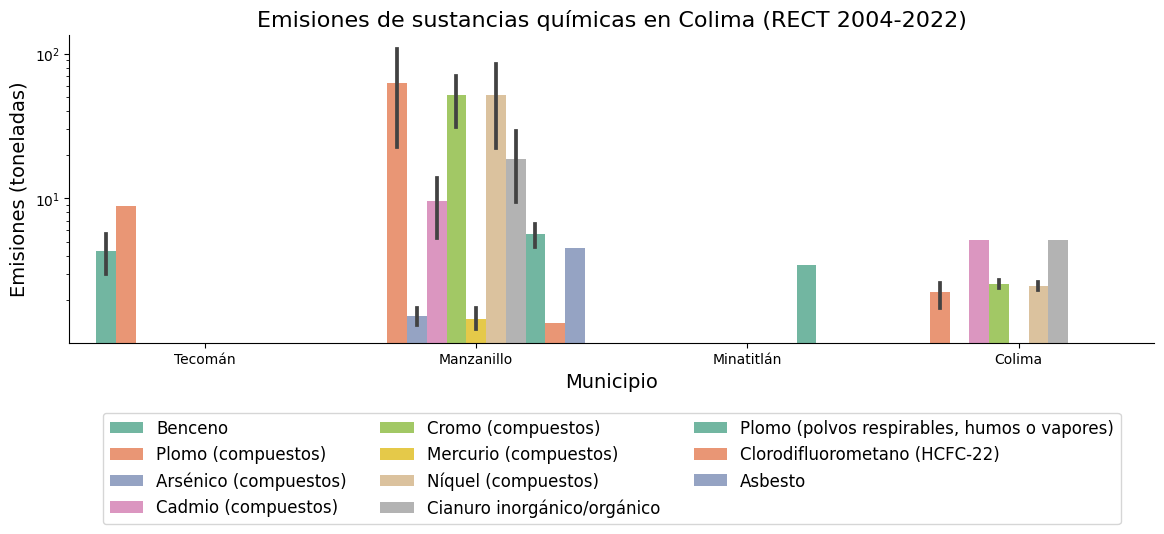

In [97]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por municipio (RECT 2004-2022)", fontsize=16)
# put values in log scale
# set scale to log
sns.barplot(x="municipio", y="emision", data=dfFinal, hue="sustancia", ax=ax, log=True, palette="Set2")

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Municipio", fontsize=14)

# add beautiful legend

ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), fontsize=12)
sns.despine()
plt.show()

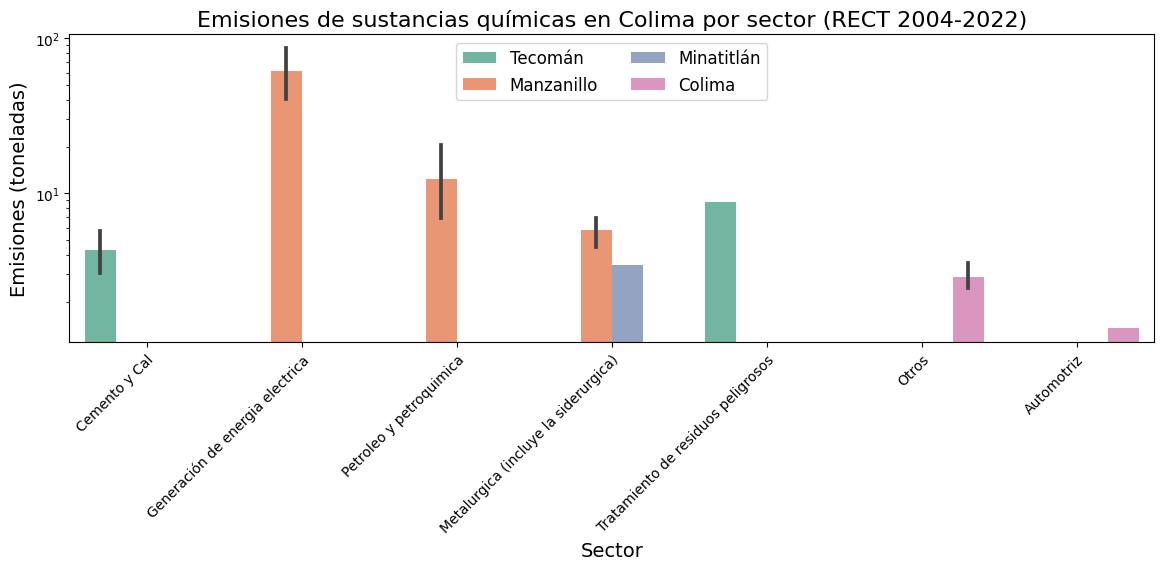

In [107]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por sector (RECT 2004-2022)", fontsize=16)

sns.barplot(x="sector", y="emision", data=dfFinal, hue="municipio", ax=ax, log=True, palette="Set2")

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Sector", fontsize=14)

# add beautiful legend

# rotate xticks 90 degrees
plt.xticks(rotation=45)

ax.legend(loc='upper center', ncol=2,  fontsize=12)

# wrap xticks labels
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

plt.show()

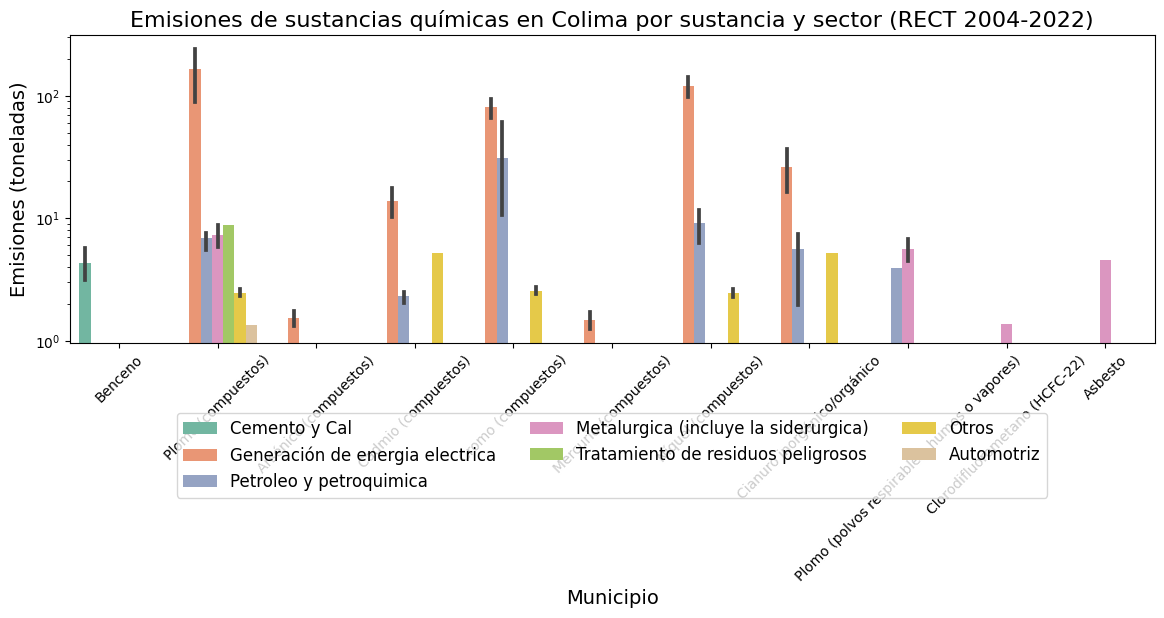

In [112]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por sustancia y sector (RECT 2004-2022)", fontsize=16)

sns.barplot(x="sustancia", y="emision", data=dfFinal, hue="sector", ax=ax, log=True, palette="Set2")

# rotate xticks 90 degrees
plt.xticks(rotation=45)
ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), fontsize=12)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Municipio", fontsize=14)



plt.show()
